So, you want to use an iterative solver. But where to start?
Let's start with setting up an example model.

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore


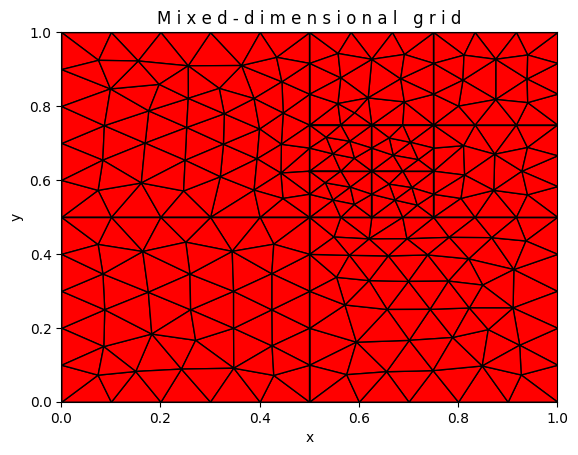

In [1]:
import porepy as pp
from porepy.examples.flow_benchmark_2d_case_1 import (
    FlowBenchmark2dCase1Model,
    solid_constants_conductive_fractures,
)

model_params = {
    "material_constants": {"solid": solid_constants_conductive_fractures},
    "grid_type": "simplex",
    "meshing_arguments": {"cell_size": 0.1},
}
model = FlowBenchmark2dCase1Model(model_params)
pp.run_time_dependent_model(model)
pp.plot_grid(model.mdg, plot_2d=True)

In [2]:
model.equation_system

EquationSystem for mixed-dimensional grid with 16 subdomains and 24 interfaces.
Variables present on at least one grid or interface:
	pressure, interface_darcy_flux
In total 3 equations, with names: 
	mass_balance_equation, interface_darcy_flux_equation, well_flux_equation

We have 3 equations (wells ignored):
* Fluid mass balance in the matrix
* Fluid mass balance in fractures
* Interface flow

And 3 corresponding variables:
* p in the matrix
* p in fractures
* v on interface

An iterative solver for a multiphysics problem in its core relies on dividing the Jacobian into several submatrices, each of which corresponds to a speficic physics. We need to define the equation and variable groups for a specific problem, that we will use to build a solver. For this, we subclass the basic `IterativeLinearSolver` mixin:

In [3]:
from iterative_solver import (
    IterativeLinearSolver,
    get_variables_group_ids,
    get_equations_group_ids,
)
from functools import cached_property


class TutorialBlockMatrix(IterativeLinearSolver):

    @cached_property
    def variable_groups(self) -> list[list[int]]:
        """Here we declare the order of variable groups, which we will use
        for indexing in a block Jacobian to declare a solver.

        """
        dim_max = self.mdg.dim_max()
        sd_ambient = self.mdg.subdomains(dim=dim_max)
        sd_lower = [
            k for i in reversed(range(0, dim_max)) for k in self.mdg.subdomains(dim=i)
        ]
        intf = self.mdg.interfaces()

        # * You can add any combination of (different) variables in one group.
        # * They don't need to have contiguous layout.
        # * The order is arbitrary and will only affect how you want to index the block matrix.

        # We want the fracture subdomains to go first (just for the sake of the example).
        return get_variables_group_ids(
            model=self,
            md_variables_groups=[  # Group 0 - pressures variables in the fractures and intersections.
                [self.pressure(sd_lower)],
                [  # Group 1 - pressures variable in the matrix.
                    self.pressure(sd_ambient),
                ],
                [self.interface_darcy_flux(intf)],  # Group 2 - interface flux variable.
            ],
        )

    @cached_property
    def equation_groups(self) -> list[list[int]]:
        dim_max = self.mdg.dim_max()
        sd_ambient = self.mdg.subdomains(dim=dim_max)
        sd_lower = [
            k for i in reversed(range(0, dim_max)) for k in self.mdg.subdomains(dim=i)
        ]
        intf = self.mdg.interfaces()

        # We want the fracture subdomain go first (just for the sake of the example).
        return get_equations_group_ids(
            model=self,
            equations_group_order=[
                [  # Group 0 - mass balance equations in fractures and intersections.
                    ("mass_balance_equation", sd_lower),
                ],
                [  # Group 1 - mass balance equations in the matrix.
                    ("mass_balance_equation", sd_ambient),
                ],
                [  # Group 2 - interface flow eq.
                    ("interface_darcy_flux_equation", intf)
                ],
            ],
        )

    # We should also provide the names for the groups, only for visualization purposes.

    def group_row_names(self):
        return ["Mass frac.", "Mass mat.", "Intf. flow"]

    def group_col_names(self):
        return ["p frac.", 'p mat.', "v intf"]

# Block matrix visualization and slicing
Now we can combine the model with the linear solver mixin and access the block matrix object, which serves these two main purposes:
* visualization
* slicing

In [4]:
class ModelWithSolver(TutorialBlockMatrix, FlowBenchmark2dCase1Model):
    pass

model = ModelWithSolver(model_params)

# It will have the block matrix available after initialization.
# Initialization:
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()

J = model.bmat  # Accessible here

There is a plenty of visualization methods for the block matrix, all of which can be helpful in different contexts.

The `plot_max` method is useful to get the general idea about the block structure. It also shows the absoulte maximum value of each group.

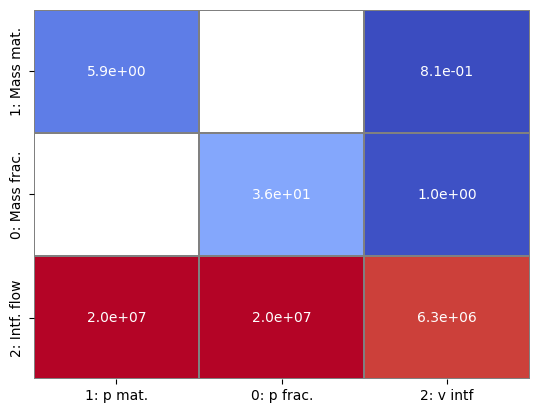

In [5]:
J.plot_max()

Group is a collection of equations / variables defined on several subdomains. Each group consists of one or more blocks. Each block corresponds to exactly one eqaution / variable defined on one subdomain.

Most of the visualization methods have the `groups: bool` parameter (the default is `True`). By setting it to `False`, you can observe each block in a group separately. This helps to investigate how different subdomains are coupled with each other.

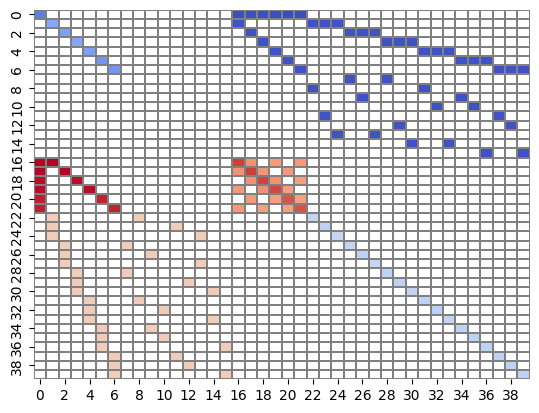

In [6]:
J.plot_max(groups=False, annot=False)

The `color_spy` method provides the sparsity structure of the matrix with colored groups.

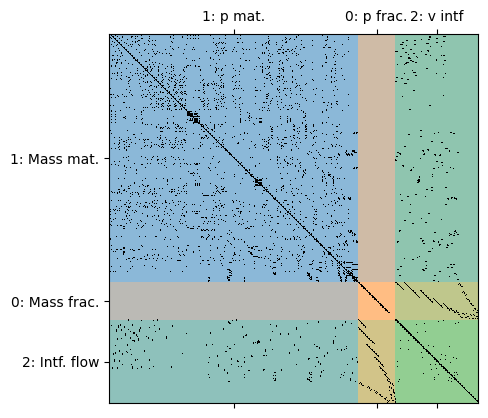

In [7]:
J.color_spy()

And for the individual blocks:

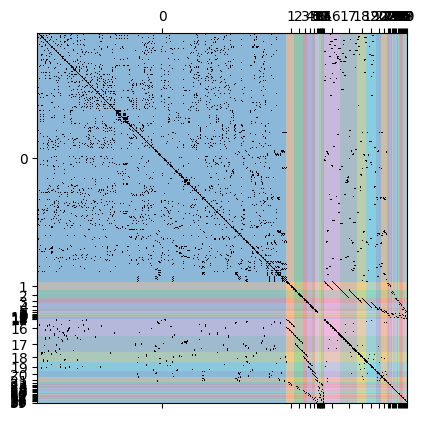

In [8]:
J.color_spy(groups=False)

Sometimes the number of degrees of freedom in the matrix is orders of magnitude higher than in the fractures. What if we want to zoom in to the fractures?

Indexing comes into play! It is less advanced than in Numpy, but still supports a lot of things: 

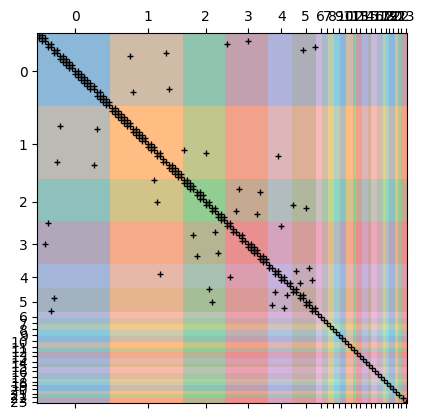

In [9]:
# We take only the equation group 2 and the variable group 2.
# A.k.a. how the intf. flow equation depends on the intf. flow variable.
J22 = J[2, 2]
J22.color_spy(groups=False)

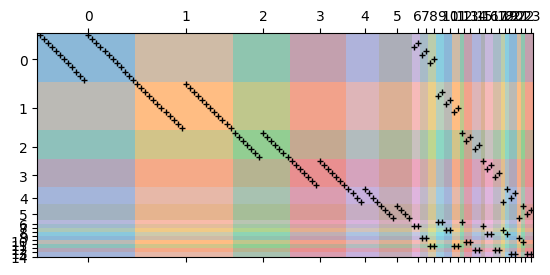

In [10]:
# We can investigate the non-diagonal blocks as well
J02 = J[0, 2]
J02.color_spy(groups=False)

<b>Note</b>: 
* Indexing works <b>only</b> for `groups`, not for the individual `blocks`. E.g. you can take group `[2, 2]`, but not the block `[15, 15]`.
* Indexing generates a copy, so must be used with causion for large matrices.

What if we want to slice several groups? We can pass a `list` of group indices: 

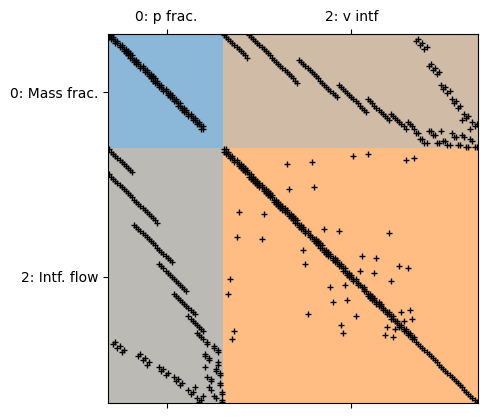

In [11]:
# We take how the equations groups 0 and 2 depend on the variable groups 0 and 2.
# A.k.a. how the fluid mass balance in fractures and the intf. flow equation depends on the pressure in fractures the intf. flow variable.
# Or simply, we excluded the ambient dimension groups.
J_no_ambient = J[[0, 2], [0, 2]]
J_no_ambient.color_spy(groups=True)

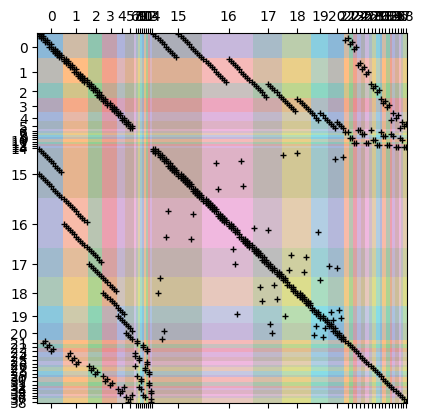

In [12]:
J_no_ambient.color_spy(groups=False)

There is a useful shortcut if you need a diagonal submatrix. If you pass only one list, it treats it as the value both for the rows and columns:

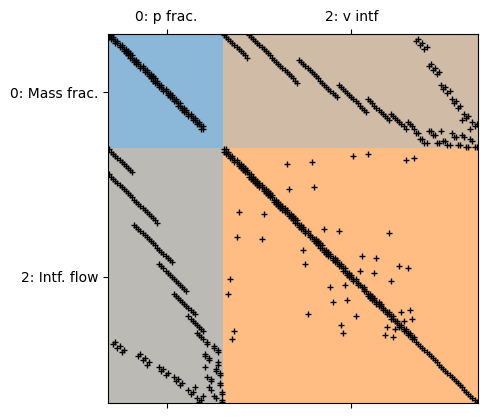

In [13]:
J[[0, 2]].color_spy()  # The same as J[[0, 2], [0, 2]]

But mind the inner `list`!

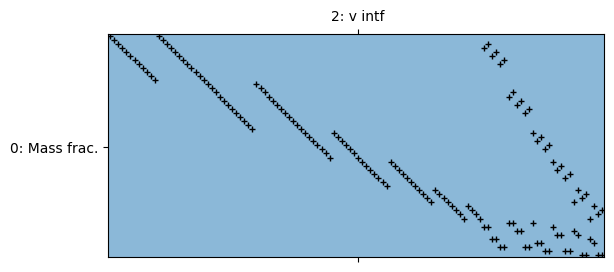

In [14]:
# This is not the same as J[[0, 2]]!
J[0, 2].color_spy()

The final thing you can do with indexing is to reorder the groups:

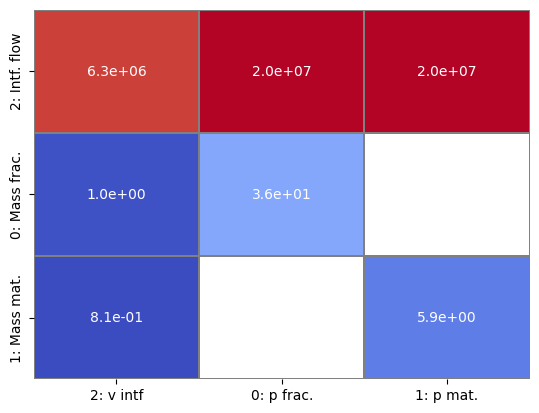

In [15]:
J[[2, 0, 1]].plot_max()
# Not that the order changed

The `colon` syntax is supported:

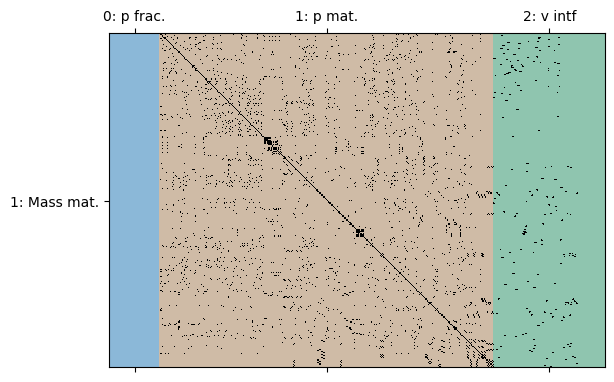

In [16]:
J[1, :].color_spy()

Back to visualization. The `matshow` method draws the nonzero matrix values, similarly to `plt.matshow`. Most useful for small submatrices.  

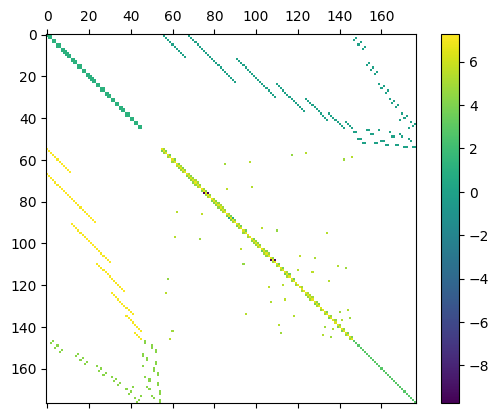

In [17]:
J[[0, 2]].matshow()

The `matshow_blocks` method is a fusion of `matshow` and `color_spy`. Sometimes can be helpful:

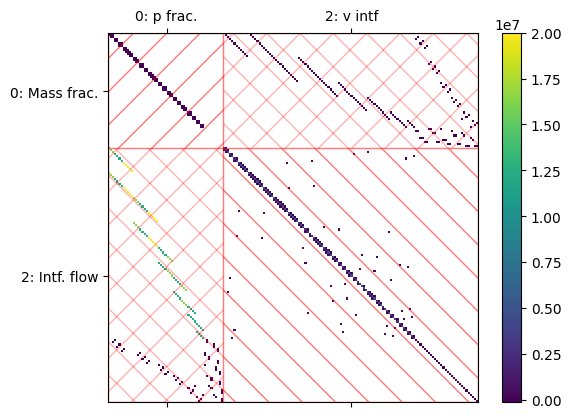

In [18]:
J[[0, 2]].matshow_blocks(log=False)

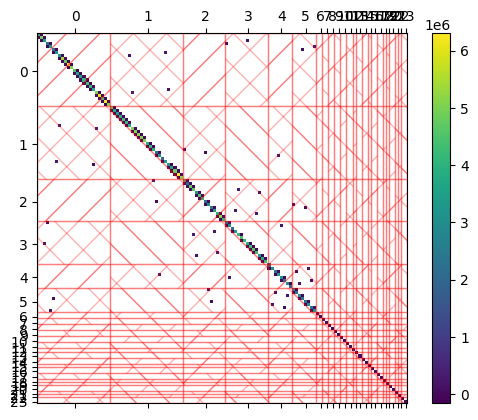

In [19]:
J[[2]].matshow_blocks(groups=False, log=False)

The right-hand side vector can also be visualized.

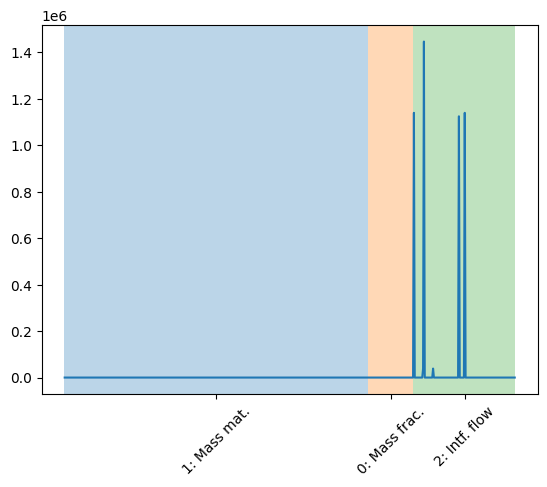

In [20]:
_, rhs_global = model.linear_system
# The rhs is stored in the original PorePy arrangement - we refer to it as 'global'.
# If we changed the arrangement, we need to permute the rhs accordingly into the 'local' arrangement.
local_rhs = J.project_rhs_to_local(rhs_global)
J.color_left_vector(local_rhs, log=False)

This also works if we consider only a submatrix.

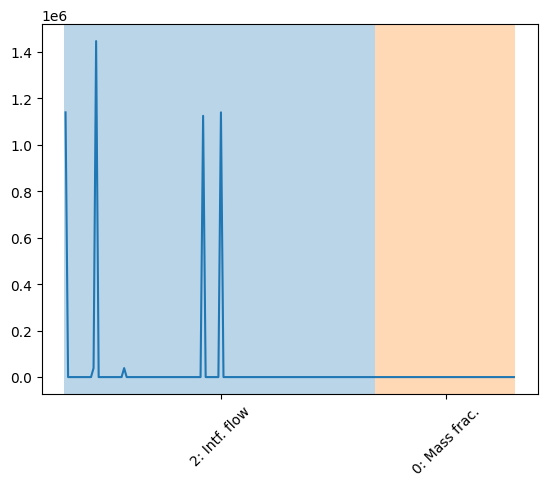

In [21]:
J02 = J[[2, 0]]
J02.color_left_vector(J02.project_rhs_to_local(rhs_global), log=False)

# Other things you can do with a block matrix

The underlying `scipy.sparse.csr_matrix` can be accessed by the `mat` property:

In [22]:
J.mat

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5124 stored elements and shape (541, 541)>

In [23]:
J[0, 2].mat

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 152 stored elements and shape (55, 122)>

You can make a copy, but this is expensive.

In [24]:
Jnew = J.copy()

What if we want to construct some operatur which benefits from the block structure, but do not want to copy a matrix? The `empty_container` method copies the groups and blocks information, but not the matrix itself.

/home/porepy/.local/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/porepy/.local/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


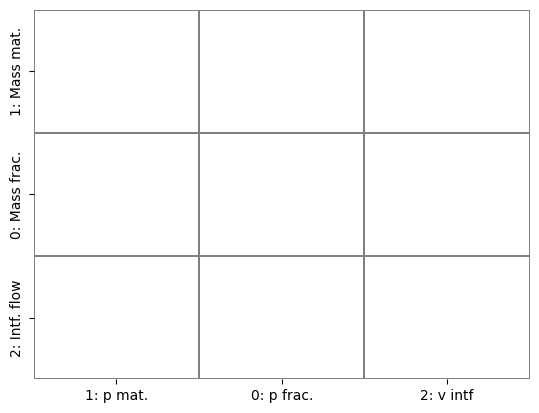

In [25]:
Q = J.empty_container()
Q.plot_max()

Now we can inicialize certain blocks. For instance, we want to construct an operator, which will contain some of the block of the Jacobian multiplied by 10:

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


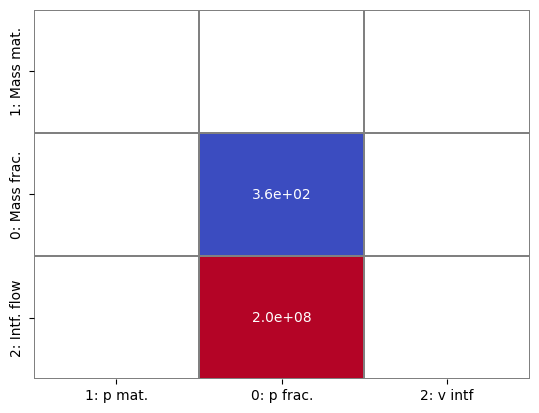

In [26]:
Q = J.empty_container()
Q[:, 0] = J[:, 0].mat * 10
Q.plot_max()

The following will not work, mind the `.mat` in the assignment.

/home/porepy/.local/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/porepy/.local/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


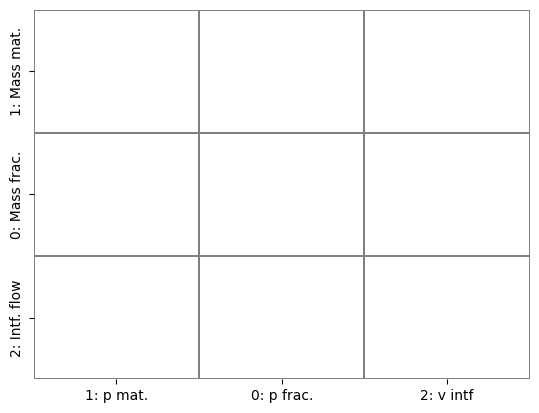

In [27]:
Q = J.empty_container()
Q[:, 0].mat = J[:, 0].mat * 10
Q.plot_max()

The last useful method is `set_zeros`, which can disable some group inplace, without changing the sparsity pattern of the matrix.

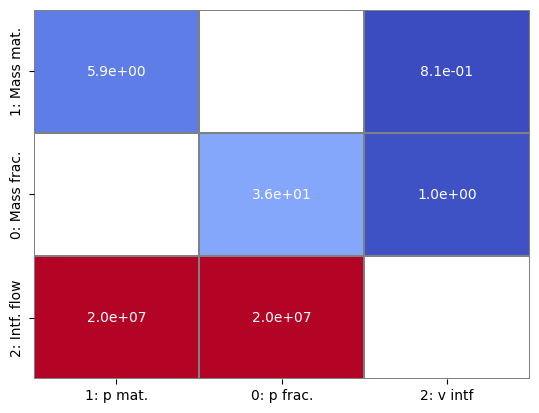

In [28]:
tmp = J.copy()
tmp.set_zeros(2, 2)
tmp.plot_max()

# Constructing a preconditioner
Now we are ready to construct the preconditioner. For this, we need to declare:
* The order of Schur complement elimination.
* How to approximately solve the eliminated submatrices.
* How to approximate their inverse to build the downstream Schur complement.

These instructions are wrapped into a `FieldSplitScheme` class. We print the block structure of the matrix one more time:

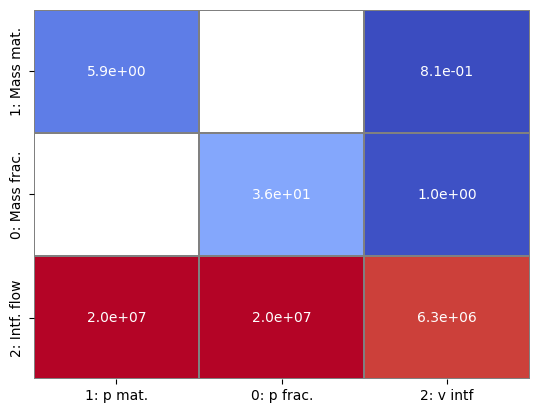

In [29]:
J.plot_max()

In [30]:
from block_matrix import FieldSplitScheme

# Import some linear algebra routines
from mat_utils import extract_diag_inv, PetscAMGFlow


class TutorialIterativeSolver(TutorialBlockMatrix):
    def make_solver_scheme(self):
        return FieldSplitScheme(
            # Eliminate the submatrix [2, 2]
            groups=[2],
            # Diagonal approximation.
            solve=lambda bmat: extract_diag_inv(bmat[[2]].mat),
            # Use the same diagonal approximation to solve [2, 2] and to build the Schur complement.
            # Sometimes, it's not possible, but this is the default option.
            invertor="use_solve",
            # Build the Schur complement by the algebraic procedure:
            # S = J[*, *] - J[*, 2] @ diag^-1(J[2, 2]) @ J[2, *]
            # Where * is the remainder of the matrix.
            # This can be changed, e.g. for physics-based approximations, but 'algebraic'
            # is the default.
            invertor_type="algebraic",
            # Passing the upper (default) factorization. The preconditioner based on the block LDU decomposition.
            # Upper facturization uses only the DU blocks.
            # Changing this to `full` (LDU) may improve robustness, but increase the computations.
            factorization_type="upper",
            # The next lines describe what to do with the remainder of the matrix.
            complement=FieldSplitScheme(
                # Eliminate the submatrix J[ [0,1], [0,1] ]
                groups=[0, 1],
                # Solving the flow in all the subdomains monolithically by the AMG setup
                solve=lambda bmat: PetscAMGFlow(bmat[[0, 1]].mat),
                # No need to provide the complement-related arguments, since these were the last blocks to eliminate.
            ),
        )

We are ready to run the iterative solver!

In [31]:
class ModelWithSolver(TutorialIterativeSolver, FlowBenchmark2dCase1Model):
    pass

model = ModelWithSolver(model_params)
pp.run_time_dependent_model(model)

There is also a function to quickly solve some linear system and plot its convergence and eigenvalues

Solve  took: 0.0
True residual: 0.0590412777244239
PETSc Converged Reason: 3


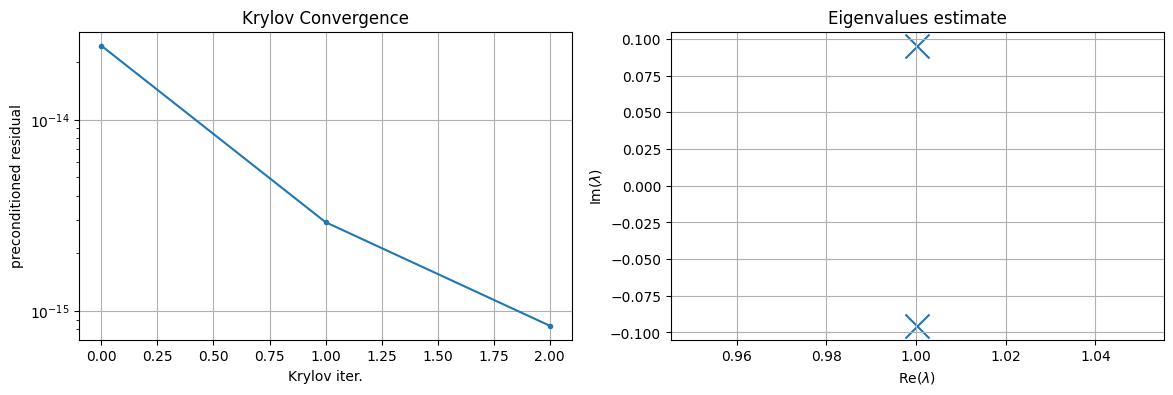

In [35]:
from plot_utils import solve_petsc_3
from block_matrix import KSPScheme

solve_petsc_3(
    J,
    ksp_scheme=KSPScheme(
        ksp="gmres",
        rtol=1e-8,
        pc_side="right",
        left_transformation=None,
        right_transformation=None,
        preconditioner=FieldSplitScheme(
            groups=[2],
            solve=lambda bmat: extract_diag_inv(bmat[[2]].mat),
            invertor="use_solve",
            invertor_type="algebraic",
            factorization_type="upper",
            complement=FieldSplitScheme(
                groups=[0, 1],
                solve=lambda bmat: PetscAMGFlow(bmat[[0, 1]].mat),
            ),
        ),
    ),
    rhs_global=model.linear_system[1],
)